# Do neonicotinoid insecticides have unintended consequences?
We will investigate the effects of neonicotinoid insecticides on bee reproduction. These insecticides are very widely used in the United States to combat aphids and other pests that damage plants.

In a recent study, Straub, et al. (Proc. Roy. Soc. B, 2016) investigated the effects of neonicotinoids on the sperm of pollinating bees. We will study how the pesticide treatment affected the count of live sperm per half milliliter of semen.

In [18]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [19]:
# Create a function to calculate ECDF given a column series
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y  

In [20]:
df = pd.read_csv('bee_sperm.csv')

In [24]:
df.head()

,Specimen,Treatment,Environment,TreatmentNCSS,Sample ID,Colony,Cage,Sample,Sperm Volume per 500 ul,Quantity,ViabilityRaw (%),Quality,Age (d),Infertil,AliveSperm,Quantity Millions,Alive Sperm Millions,Dead Sperm Millions
0,227,Control,Cage,1,C2-1-1,2,1,1,2150000,2150000,96.72638146,96.726381,14,0,2079617,2.1500,2.079617,0.070383
1,228,Control,Cage,1,C2-1-2,2,1,2,2287500,2287500,96.34980798,96.349808,14,0,2204001,2.2875,2.204001,0.083499
2,229,Control,Cage,1,C2-1-3,2,1,3,87500,87500,98.75,98.750000,14,0,86406,0.0875,0.086406,0.001094
3,230,Control,Cage,1,C2-1-4,2,1,4,1875000,1875000,93.28742083,93.287421,14,0,1749139,1.8750,1.749139,0.125861
4,231,Control,Cage,1,C2-1-5,2,1,5,1587500,1587500,97.79250611,97.792506,14,0,1552456,1.5875,1.552456,0.035044


In [25]:
df.Treatment.value_counts()

Control      145
Pesticide     90
Name: Treatment, dtype: int64

## Do some initial EDA

Plot ECDFs of the alive sperm count for untreated bees (stored in the Numpy array `control`) and bees treated with pesticide (stored in the Numpy array `treated`)

In [29]:
control = df.query('Treatment == "Control"')['Alive Sperm Millions']
treated = df.query('Treatment == "Pesticide"')['Alive Sperm Millions']

In [32]:
# Compute x,y values for ECDFs
x_control, y_control = ecdf(control)
x_treated, y_treated = ecdf(treated)

Text(0, 0.5, 'ECDF')

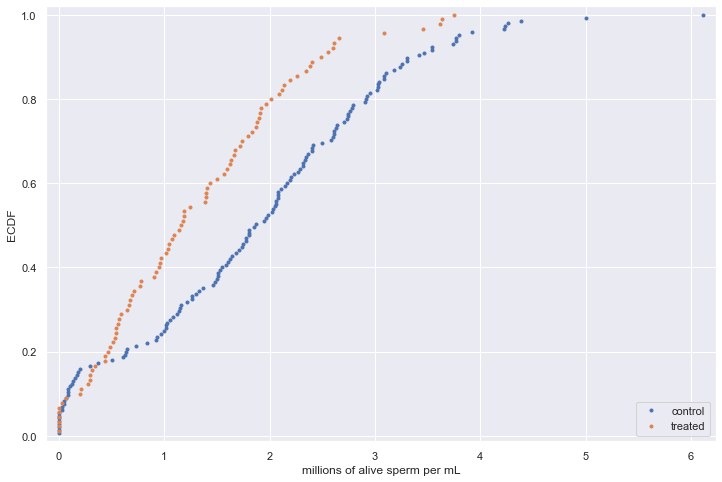

In [37]:
# Plot the ECDFs
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x_control,y_control, marker='.', linestyle='none')
plt.plot(x_treated, y_treated, marker='.', linestyle='none')

# Set the margins
plt.margins(0.02)

# Add a legend
plt.legend(('control', 'treated'), loc='lower right')

# Label axes and show plot
plt.xlabel('millions of alive sperm per mL')
plt.ylabel('ECDF')

The ECDFs show a pretty clear difference between the treatment and control; treated bees have fewer alive sperm.

## Bootstrap hypothesis test on bee sperm counts

We will test the following hypothesis: On average, male bees treated with neonicotinoid insecticide have the same number of active sperm per milliliter of semen than do untreated male bees. We will use the difference of means as our test statistic.


### First create necessary functions

In [38]:
# Bootstrap replicate function
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [39]:
def draw_bs_reps(data, func, size=1):
    """ Draw bootstrap replicates."""
    
    # Initialize array of replicates bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

In [40]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [44]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data2):]

    return perm_sample_1, perm_sample_2

In [45]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [59]:
# Compute the difference in mean sperm count: diff_means
diff_means = diff_of_means(control, treated)

# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate((control, treated)))

print(f" diff of means for actual data: {diff_means}")
print(f" mean of pooled data: {mean_count}")

 diff of means for actual data: 0.5730293647509577
 mean of pooled data: 1.6533190212765958


In [54]:
# Generate shifted data sets
control_shifted = control - np.mean(control) + mean_count
treated_shifted = treated - np.mean(treated) + mean_count

In [55]:
# Generate bootstrap replicates
bs_reps_control = draw_bs_reps(control_shifted,
                       np.mean, size=10000)
bs_reps_treated = draw_bs_reps(treated_shifted,
                       np.mean, size=10000)

In [56]:
# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_control - bs_reps_treated

In [60]:
# Compute and print p-value: p
p = np.sum(bs_replicates >= diff_means) \
            / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


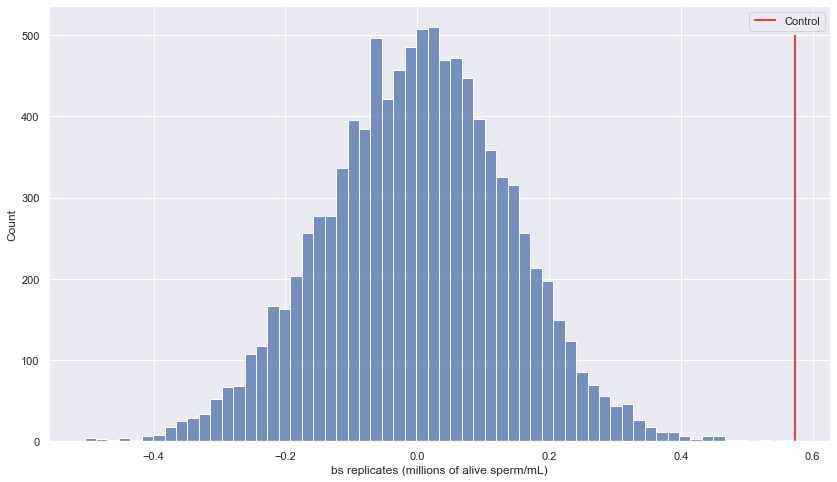

In [61]:
# Plot the distribution histogram with the observed value to confirm the p-value of zero 
plt.figure(figsize=(14, 8))
sns.histplot(bs_replicates)
plt.vlines(diff_means,ymin=0, ymax=500,color='red', linestyle='-', label='Control')
plt.xlabel('bs replicates (millions of alive sperm/mL)')
plt.legend()

The p-value is small, most likely less than 0.0001, since you never saw a bootstrap replicated with a difference of means at least as extreme as what was observed.